## Import Packages

In [1]:
import plotly
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as pximport 
import itertools
# from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer

from scipy import optimize

## Import Data

In [3]:
systematic_noise_df = pd.read_csv(
    '../data/conll_noise_induction/systematic_error.csv'
)

random_noise_df = pd.read_csv(
    '../data/conll_noise_induction/random_error.csv'
)

denoise_df = pd.read_csv(
    '../data/conll_noise_induction/denoise.csv'
)

In [4]:
# General Functions
def func_exp(x, a, b, c):
    """Return values from a general exponential function."""
    return a * np.exp(b * x) + c


def func_log(x, a, b, c):
    """Return values from a general log function."""
    return a * np.log(b * x) + c


# Helper
def generate_data(func, *args, jitter=0):
    """Return a tuple of arrays with random data along a general function."""
    xs = np.linspace(1, 5, 50)
    ys = func(xs, *args)
    noise = jitter * np.random.normal(size=len(xs)) + jitter
    xs = xs.reshape(-1, 1)                                  # xs[:, np.newaxis]
    ys = (ys + noise).reshape(-1, 1)
    return xs, ys

In [5]:
def plot_after_sorting(x_col, y_col, data):
    
    x, y = data[x_col], data[y_col]
#     lists = sorted(itertools.izip(*[x, y]))
#     new_x, new_y = list(itertools.izip(*lists))
    new_x, new_y = zip(*sorted(zip(x, y)))
    
    plt.plot(new_x, new_y)
    plt.show()

In [6]:
def reorder_for_plotting(x_col, y_col, data):
    x, y = data[x_col], data[y_col]
    new_x, new_y = zip(*sorted(zip(x, y)))
    
    return new_x, new_y

In [7]:
# our Worker F1 and test accuracy are all decimals, whereas model metrics are not. 
# we need to multiply Worker metrics by 100 for consistency. 

systematic_noise_df['worker_avg_f1'] = systematic_noise_df['worker_avg_f1'] * 100
systematic_noise_df['test_accuracy'] = systematic_noise_df['test_accuracy'] * 100

random_noise_df['worker_avg_f1'] = random_noise_df['worker_avg_f1'] * 100
random_noise_df['test_accuracy'] = random_noise_df['test_accuracy'] * 100

denoise_df['worker_avg_f1'] = denoise_df['worker_avg_f1'] * 100
denoise_df['test_accuracy'] = denoise_df['test_accuracy'] * 100

In [8]:
# create log transformer for fitted function
transformer = FunctionTransformer(np.log, validate=True)

In [31]:
# colours for graphs

colour_dict = {
    1: "#D81B60",
    2: "#1E88E5",
    3: "#FFC107",
    4: "#004D40"
}

## Systematic Noise

In [10]:
systematic_noise_df.head()

,noise_prop,worker_avg_f1,worker_std_f1,test_accuracy,model_precision,model_recall,model_f1
0,0.00,61.120755,0.171028,92.841011,67.77,58.41,62.74
1,0.02,59.929287,0.167551,92.607375,67.59,57.32,62.03
2,0.04,58.635514,0.164028,92.422413,65.02,57.40,60.97
3,0.06,57.909218,0.160629,92.706670,69.03,57.79,62.91
4,0.08,56.399369,0.156127,92.632686,67.85,57.57,62.29


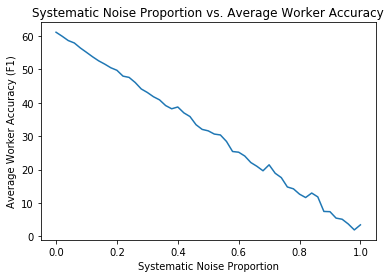

In [11]:
x, y = reorder_for_plotting('noise_prop', 'worker_avg_f1', data=systematic_noise_df)
plt.plot(x, y)
plt.xlabel('Systematic Noise Proportion')
# plt.xlim(0, 1)
plt.ylabel('Average Worker Accuracy (F1)')
# plt.ylim(0, 1)
plt.title('Systematic Noise Proportion vs. Average Worker Accuracy')
plt.show()

In [12]:
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=systematic_noise_df)

x_reshaped = np.array(x).reshape([51,1])
y_trans = transformer.fit_transform(np.array(y).reshape([51,1]))             # 1

x_trans = transformer.fit_transform(np.array(x).reshape([51,1]))
y_reshaped = np.array(y).reshape([51,1])


# Regression
regressor = LinearRegression()
results = regressor.fit(x_trans, y_reshaped)                # 2
model = results.predict
y_fit = model(x_trans)

In [13]:
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

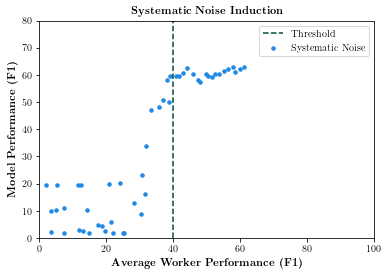

In [32]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

f = plt.figure()
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=systematic_noise_df)
plt.scatter(x, y, label = 'Systematic Noise', color = colour_dict[2], s=12)
# plt.plot(x, y_fit, "k--", label='fitted function')
# plt.plot(x, p(x), "k--", label='fitted function')

# add threshold
plt.axvline(x=40, linestyle='dashed', color=colour_dict[4], label = 'Threshold')

plt.legend(loc='best')
plt.xlabel(r'\textbf{Average Worker Performance (F1)}', fontsize = 11)
plt.xlim(0, 100)
plt.ylim(0, 80)
plt.ylabel(r'\textbf{Model Performance (F1)}', fontsize = 11)
plt.title(r'\textbf{Systematic Noise Induction}', fontsize = 11)
plt.show()

# save as pdf
f.savefig("systematic_noise.pdf", bbox_inches='tight')

## Random Noise

In [38]:
random_noise_df.head()

,noise_prop,worker_avg_f1,worker_std_f1,test_accuracy,model_precision,model_recall,model_f1
0,0.00,61.120755,0.171028,92.733928,67.09,57.97,62.20
1,0.02,60.015821,0.167162,92.437989,66.90,55.46,60.65
2,0.04,59.063098,0.164617,92.687201,68.80,55.33,61.33
3,0.06,57.836609,0.161588,92.441883,68.64,54.13,60.53
4,0.08,56.901910,0.159278,92.548966,67.46,55.78,61.07


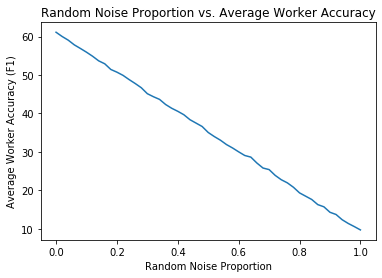

In [7]:
x, y = reorder_for_plotting('noise_prop', 'worker_avg_f1', data=random_noise_df)
plt.plot(x, y)
plt.xlabel('Random Noise Proportion')
# plt.xlim(0, 1)
plt.ylabel('Average Worker Accuracy (F1)')
# plt.ylim(0, 1)
plt.title('Random Noise Proportion vs. Average Worker Accuracy')
plt.show()

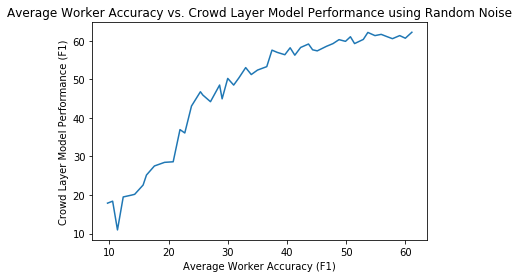

In [8]:
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_df)
plt.plot(x, y)
plt.xlabel('Average Worker Accuracy (F1)')
# plt.xlim(0, 1)
plt.ylabel('Crowd Layer Model Performance (F1)')
# plt.ylim(0, 1)
plt.title('Average Worker Accuracy vs. Crowd Layer Model Performance using Random Noise')
plt.show()

In [12]:
# x_reshaped = np.array(x).reshape([50,1])
# y_trans = transformer.fit_transform(np.array(y).reshape([50,1]))             # 1

x_trans = transformer.fit_transform(np.array(x).reshape([50,1]))
y_reshaped = np.array(y).reshape([50,1])


# Regression
regressor = LinearRegression()
results = regressor.fit(x_trans, y_reshaped)                # 2
model = results.predict
y_fit = model(x_trans)

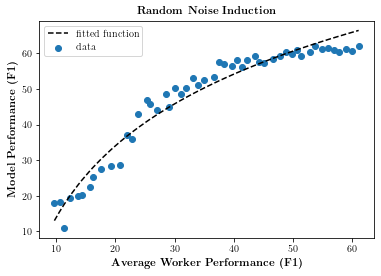

In [20]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

f = plt.figure()

x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_df)
plt.scatter(x, y, label = 'data')
plt.plot(x, y_fit, "k--", label='fitted function')
plt.legend(loc='best')
plt.xlabel(r'\textbf{Average Worker Performance (F1)}', fontsize = 11)
plt.ylabel(r'\textbf{Model Performance (F1)}', fontsize = 11)
plt.title(r'\textbf{Random Noise Induction}', fontsize = 11)
plt.show()

# save as pdf
f.savefig("random_noise.pdf", bbox_inches='tight')

## De-Noise

In [15]:
denoise_df.head()

,noise_prop,worker_avg_f1,worker_std_f1,test_accuracy,model_precision,model_recall,model_f1
0,0.00,61.120755,0.171028,92.733928,66.74,58.12,62.14
1,0.02,62.169428,0.166566,92.737822,66.49,59.10,62.58
2,0.04,62.865310,0.162204,92.677466,65.98,59.07,62.33
3,0.06,63.791245,0.156103,92.817647,67.48,57.45,62.06
4,0.08,64.811062,0.152893,93.057124,67.50,60.23,63.66


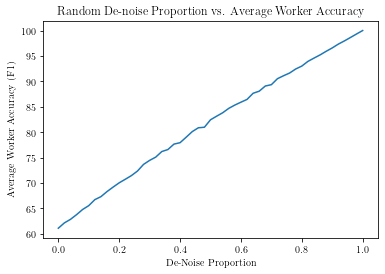

In [16]:
x, y = reorder_for_plotting('noise_prop', 'worker_avg_f1', data=denoise_df)
plt.plot(x, y)
plt.xlabel('De-Noise Proportion')
# plt.xlim(0, 1)
plt.ylabel('Average Worker Accuracy (F1)')
# plt.ylim(0, 1)
plt.title('Random De-noise Proportion vs. Average Worker Accuracy')
plt.show()

In [22]:
# x_reshaped = np.array(x).reshape([50,1])
# y_trans = transformer.fit_transform(np.array(y).reshape([50,1]))             # 1

x_trans = transformer.fit_transform(np.array(x).reshape([51,1]))
y_reshaped = np.array(y).reshape([51,1])


# Regression
regressor = LinearRegression()
results = regressor.fit(x_trans, y_reshaped)                # 2
model = results.predict
y_fit = model(x_trans)

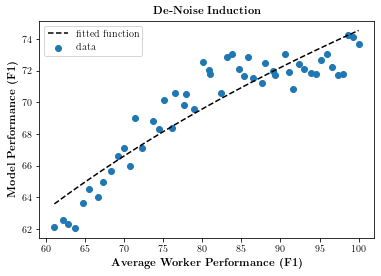

In [23]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

f = plt.figure()

x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=denoise_df)
plt.scatter(x, y, label = 'data')
plt.plot(x, y_fit, "k--", label='fitted function')
plt.legend(loc='best')
plt.xlabel(r'\textbf{Average Worker Performance (F1)}', fontsize = 11)
plt.ylabel(r'\textbf{Model Performance (F1)}', fontsize = 11)
plt.title(r'\textbf{De-Noise Induction}', fontsize = 11)
plt.show()

# save as pdf
f.savefig("de_noise.pdf", bbox_inches='tight')

## Random Noise - Combined Noise and Denoise

In [9]:
random_noise_combined_df = random_noise_df.append(denoise_df, ignore_index=True)
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_combined_df)

In [12]:
# x_reshaped = np.array(x).reshape([50,1])
# y_trans = transformer.fit_transform(np.array(y).reshape([50,1]))             # 1

x_trans = transformer.fit_transform(np.array(x).reshape([101,1]))
y_reshaped = np.array(y).reshape([101,1])


# Regression
regressor = LinearRegression()
results = regressor.fit(x_trans, y_reshaped)                # 2
model = results.predict
y_fit = model(x_trans)

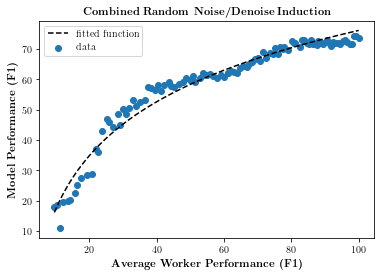

In [14]:
# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

f = plt.figure()

x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_combined_df)
plt.scatter(x, y, label = 'data')
plt.plot(x, y_fit, "k--", label='fitted function')
plt.legend(loc='best')
plt.xlabel(r'\textbf{Average Worker Performance (F1)}', fontsize = 11)
plt.ylabel(r'\textbf{Model Performance (F1)}', fontsize = 11)
plt.title(r'\textbf{Combined Random Noise/Denoise Induction}', fontsize = 11)
plt.show()

# save as pdf
f.savefig("random_noise_combined.pdf", bbox_inches='tight')

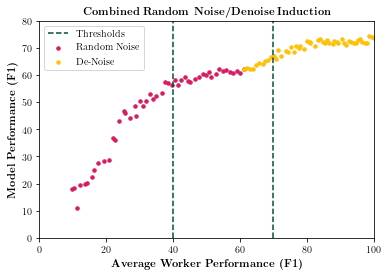

In [33]:
# this time plot separately on same graph

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

f = plt.figure()

# random noise
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=random_noise_df)
plt.scatter(x, y, label = 'Random Noise', color = colour_dict[1], s = 12)

# denoise
x, y = reorder_for_plotting('worker_avg_f1', 'model_f1', data=denoise_df)
plt.scatter(x, y, label = 'De-Noise', color = colour_dict[3], s = 12)

# add thresholds
plt.axvline(x=40, linestyle='dashed', color=colour_dict[4], label = 'Thresholds')
plt.axvline(x=70, linestyle='dashed', color=colour_dict[4])

plt.xlim(0, 100)
plt.ylim(0, 80)
plt.legend(loc='best')
plt.xlabel(r'\textbf{Average Worker Performance (F1)}', fontsize = 11)
plt.ylabel(r'\textbf{Model Performance (F1)}', fontsize = 11)
plt.title(r'\textbf{Combined Random Noise/Denoise Induction}', fontsize = 11)
plt.show()

# save as pdf
f.savefig("random_noise_combined.pdf", bbox_inches='tight')